In [1]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
from tqdm.notebook import tqdm
import math
from sklearn.metrics import confusion_matrix
import seaborn as sn
torch.manual_seed(0)

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
dir_list = os.listdir('free-spoken-digit-dataset-master/recordings/')
print(f'Recordings : {dir_list[0:5]}')

Recordings : ['9_jackson_30.wav', '5_nicolas_41.wav', '7_george_15.wav', '7_jackson_8.wav', '4_jackson_26.wav']


In [4]:
path = []
labels = []
for i in dir_list:
    path.append('free-spoken-digit-dataset-master/recordings/'+str(i))
    labels.append(i.split('_')[0])
data = pd.DataFrame({'path':path,'label':labels})
data.to_csv('data_path.csv')

In [5]:
data.head()

,path,label
0,free-spoken-digit-dataset-master/recordings/9_...,9
1,free-spoken-digit-dataset-master/recordings/5_...,5
2,free-spoken-digit-dataset-master/recordings/7_...,7
3,free-spoken-digit-dataset-master/recordings/7_...,7
4,free-spoken-digit-dataset-master/recordings/4_...,4


In [6]:
df_X = pd.DataFrame(columns=['tensor','sr'])

tensors = []
srs = []
for i in data['path']:
    data_waveform, rate_of_sample = torchaudio.load(i)
    tensors.append(data_waveform)
    srs.append(rate_of_sample)
df_X['tensor'] = tensors
df_X['sr'] = srs
df_X = pd.concat([data,df_X],axis=1)
df_X=df_X.fillna(0)

In [7]:
def get_dataset_partitions_pd(df, train_split=0.8, val_split=0.1, test_split=0.1, target_variable=None):
    assert (train_split + test_split + val_split) == 1
    
    df_sample = df.sample(frac=1, random_state=42)

    if target_variable is not None:
        grouped_df = df_sample.groupby(target_variable)
        arr_list = [np.split(g, [int(train_split * len(g)), int((1 - val_split) * len(g))]) for i, g in grouped_df]

        train_ds = pd.concat([t[0] for t in arr_list])
        val_ds = pd.concat([t[1] for t in arr_list])
        test_ds = pd.concat([v[2] for v in arr_list])

    else:
        indices_or_sections = [int(train_split * len(df)), int((1 - val_split) * len(df))]
        train_ds, val_ds, test_ds = np.split(df_sample, indices_or_sections)
    
    return train_ds, val_ds, test_ds

In [8]:
train_ds, test_ds, val_ds  = get_dataset_partitions_pd(df_X.drop(['path'],axis=1),train_split=0.8, val_split=0.1, test_split=0.1, target_variable='label')

In [9]:
print(f'train_ds.shape: {train_ds.shape}\n\n'+
      f'val_ds.shape: {val_ds.shape}\n\n'+
      f'test_ds.shape: {test_ds.shape}\n\n')

train_ds.shape: (2400, 3)

val_ds.shape: (300, 3)

test_ds.shape: (300, 3)




In [10]:
print(f'Distribution in training set: \n{train_ds.label.value_counts().sort_index() / len(train_ds)}\n\n'+
      f'Distribution in validation set: \n{val_ds.label.value_counts().sort_index() / len(val_ds)}\n\n'+
    f'Distribution in testing set: \n{test_ds.label.value_counts().sort_index() / len(test_ds)}')

Distribution in training set: 
0    0.1
1    0.1
2    0.1
3    0.1
4    0.1
5    0.1
6    0.1
7    0.1
8    0.1
9    0.1
Name: label, dtype: float64

Distribution in validation set: 
0    0.1
1    0.1
2    0.1
3    0.1
4    0.1
5    0.1
6    0.1
7    0.1
8    0.1
9    0.1
Name: label, dtype: float64

Distribution in testing set: 
0    0.1
1    0.1
2    0.1
3    0.1
4    0.1
5    0.1
6    0.1
7    0.1
8    0.1
9    0.1
Name: label, dtype: float64


In [11]:
train_set = train_ds[['tensor', 'sr', 'label']].to_numpy()
validation_set = val_ds[['tensor', 'sr', 'label']].to_numpy()
test_set = test_ds[['tensor', 'sr', 'label']].to_numpy()

In [12]:
waveform0, sample_rate0, numclass0 = train_set[0]
waveform1, sample_rate1, numclass1 = validation_set[0]
waveform2, sample_rate2, numclass2 = test_set[0]

In [13]:
waveform2

tensor([[-0.0004, -0.0008, -0.0002,  ..., -0.0002, -0.0003, -0.0005]])

In [14]:
print('Sample of training set')
waveform0, sample_rate0, numclass0

Sample of training set


(tensor([[ 0.0005,  0.0002,  0.0003,  ..., -0.0005, -0.0002,  0.0001]]),
 8000,
 '0')

In [15]:
waveform0.shape

torch.Size([1, 4455])

In [16]:
print('Sample first entry of validation set')
waveform1, sample_rate1, numclass1

Sample first entry of validation set


(tensor([[-0.0101, -0.0121, -0.0153,  ..., -0.0081, -0.0084, -0.0098]]),
 8000,
 '0')

In [17]:
print('Sample first entry of test set')
waveform2, sample_rate2, numclass2

Sample first entry of test set


(tensor([[-0.0004, -0.0008, -0.0002,  ..., -0.0002, -0.0003, -0.0005]]),
 8000,
 '0')

In [18]:
print('Sample 500th entry of all sets\n')
train_set[200], validation_set[200], test_set[200]

Sample 500th entry of all sets



(array([tensor([[ 0.0000,  0.0003,  0.0001,  ..., -0.0005, -0.0005, -0.0002]]),
        8000, '0'], dtype=object),
 array([tensor([[ 0.0033, -0.0040,  0.0033,  ...,  0.0073,  0.0050,  0.0017]]),
        8000, '6'], dtype=object),
 array([tensor([[ 0.0000,  0.0000, -0.0156,  ..., -0.0078,  0.0000, -0.0078]]),
        8000, '6'], dtype=object))

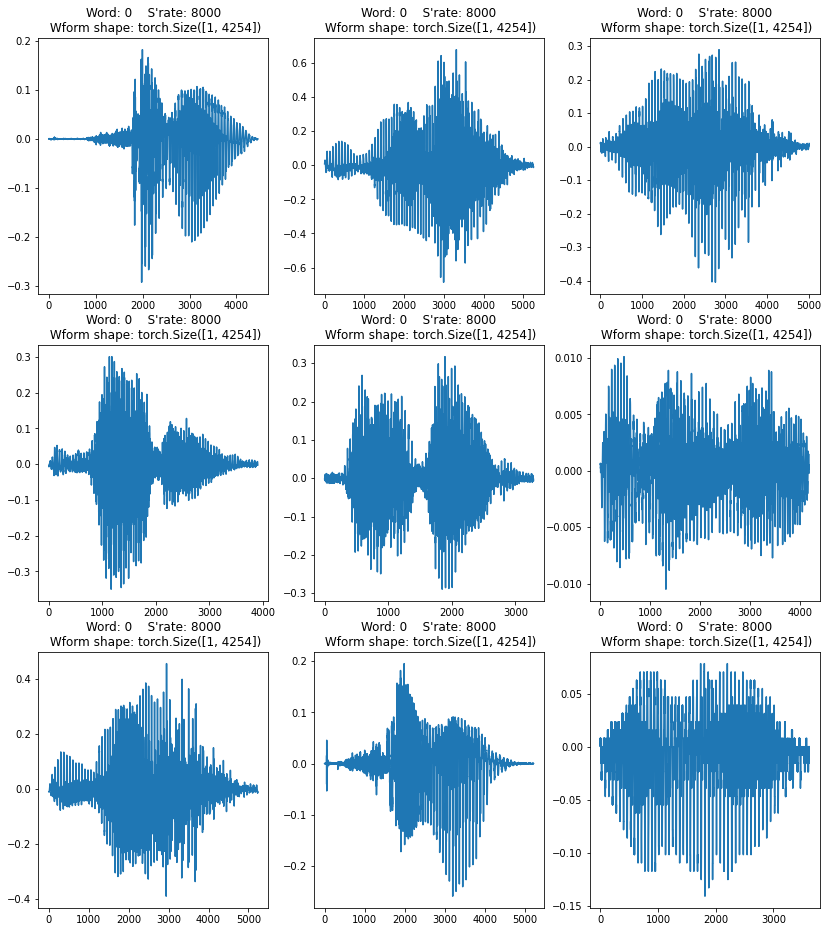

In [19]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(14, 16))
for i in range (9):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    ax.plot(train_set[i][0].t().numpy())
    ax.set_title(f"Word: {test_set[i][2]}    S'rate: {test_set[i][1]}" + f'\n Wform shape: {waveform2.size()}')

plt.show()

In [20]:
numclasses = sorted(list(set(element[2] for element in train_set)))
numclasses

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

In [21]:
print('Total number of entries in training set :', (len(train_set)))
print('Total number of entries in validation set :', (len(validation_set)))
print('Total number of entries in test set :', (len(test_set)))

Total number of entries in training set : 2400
Total number of entries in validation set : 300
Total number of entries in test set : 300


In [22]:
print('Total number of entries in training set :', (len(train_set)))
print('Number of num class entries :', (len(numclasses)))
print('\nNum class : Count')
for j in range (len(numclasses)):
    count = 0
    for i in range (len(train_set)):
        if (train_set[i][2]==numclasses[j]):
            count=count+1
    print(numclasses[j], ' :', count)

Total number of entries in training set : 2400
Number of num class entries : 10

Num class : Count
0  : 240
1  : 240
2  : 240
3  : 240
4  : 240
5  : 240
6  : 240
7  : 240
8  : 240
9  : 240


In [23]:
print('Total number of entries in validation set :', (len(validation_set)))
print('Number of num class entries :', (len(numclasses)))
print('\nNum class : Count')
for j in range (len(numclasses)):
    count = 0
    for i in range (len(validation_set)):
        if (validation_set[i][2]==numclasses[j]):
            count=count+1
    print(numclasses[j], ' :', count)

Total number of entries in validation set : 300
Number of num class entries : 10

Num class : Count
0  : 30
1  : 30
2  : 30
3  : 30
4  : 30
5  : 30
6  : 30
7  : 30
8  : 30
9  : 30


In [24]:
print('Total number of entries in test set :', (len(test_set)))
print('Number of num class entries :', (len(numclasses)))
print('\nNum class : Count')
for j in range (len(numclasses)):
    count = 0
    for i in range (len(test_set)):
        if (test_set[i][2]==numclasses[j]):
            count=count+1
    print(numclasses[j], ' :', count)

Total number of entries in test set : 300
Number of num class entries : 10

Num class : Count
0  : 30
1  : 30
2  : 30
3  : 30
4  : 30
5  : 30
6  : 30
7  : 30
8  : 30
9  : 30


In [25]:
waveform_test, *_ = test_set[0]
print(test_set[0])
ipd.Audio(waveform_test.numpy(), rate=sample_rate2)

[tensor([[-0.0004, -0.0008, -0.0002,  ..., -0.0002, -0.0003, -0.0005]])
 8000 '0']


In [26]:
new_sr = 16000
transform = torchaudio.transforms.Resample(orig_freq=sample_rate2, new_freq=new_sr)
transformed = transform(waveform_test)

ipd.Audio(transformed.numpy(), rate=new_sr)

In [27]:
def index_to_numclass(index):
    return numclasses[index]

def numclass_to_index(word):
    return torch.tensor(numclasses.index(word))

In [28]:
def pad_sequence(batch):
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)

In [29]:
def collate_fn(batch):
    tensors, targets = [], []
    for waveform, _, numclass, *_ in batch:
        tensors += [waveform]
        targets += [numclass_to_index(numclass)]
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets

In [30]:
batch_size = 32

In [31]:
if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

In [32]:
#Dataloaders
train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
        drop_last=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
validation_loader = torch.utils.data.DataLoader(
    validation_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

In [33]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

## M3GRU definition

In [34]:
class M3GRU(nn.Module):
    def __init__(self, n_input, hidden_dim, n_layers, n_output=10, stride=4, n_channel=3):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        self.conv1 = nn.Conv1d(n_input, 2*n_channel, kernel_size=160, stride=stride)
        self.bn1 = nn.BatchNorm1d(2*n_channel)
        self.relu1 = nn.LeakyReLU()
        self.pool1 = nn.MaxPool1d(4)
        
        self.conv2 = nn.Conv1d(2*n_channel, 2*n_channel, kernel_size=6, stride=1, padding=1)
        self.bn2 = nn.BatchNorm1d(2*n_channel)
        self.relu2 = nn.LeakyReLU()
        self.pool2 = nn.MaxPool1d(4)
        
        self.fc1 = nn.Linear(2*n_channel, n_channel)
        self.relu3 = nn.LeakyReLU()
        
        self.gru1 = nn.GRU(n_channel, hidden_dim, n_layers, batch_first=True, bidirectional=False, dropout=0)
        self.fc2 = nn.Linear(hidden_dim, n_output)
        self.relu4 = nn.LeakyReLU()
       

    def forward(self, x, h):
        x = self.conv1(x)
        x = self.relu1(self.bn1(x))
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.relu2(self.bn2(x))
        x = self.pool2(x)
        
        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(self.relu3(x))
        
        x, h = self.gru1(x, h)
        x = self.fc2(self.relu4(x[:,-1]))
        
        #x = self.rnn(x)
        
        return F.log_softmax(x, dim=1), h
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device)
        return hidden

print('M3 model')
print('Model n_input', transformed.shape[0])
print('Model n_output', len(numclasses))
print('transformed :', transformed[0])

n_input=transformed.shape[0]
hidden_dim = 32
n_layers = 2
n_output=len(numclasses)

model_M3GRU = M3GRU(n_input=n_input, hidden_dim=hidden_dim, n_layers=n_layers , n_output=n_output)
model_M3GRU.to(device)
print(model_M3GRU)

n = count_parameters(model_M3GRU)
print("Number of parameters: %s" % n)

M3 model
Model n_input 1
Model n_output 10
transformed : tensor([-0.0004, -0.0007, -0.0008,  ..., -0.0004, -0.0005, -0.0003])
M3GRU(
  (conv1): Conv1d(1, 6, kernel_size=(160,), stride=(4,))
  (bn1): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): LeakyReLU(negative_slope=0.01)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(6, 6, kernel_size=(6,), stride=(1,), padding=(1,))
  (bn2): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): LeakyReLU(negative_slope=0.01)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=6, out_features=3, bias=True)
  (relu3): LeakyReLU(negative_slope=0.01)
  (gru1): GRU(3, 32, num_layers=2, batch_first=True)
  (fc2): Linear(in_features=32, out_features=10, bias=True)
  (relu4): LeakyReLU(negative_slope=0.01)
)
Number of parameters: 11451


## M5GRU definition

In [35]:
class M5GRU(nn.Module):
    def __init__(self, n_input, hidden_dim, n_layers, n_output=10, stride=4, n_channel=5):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=160, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.relu1 = nn.LeakyReLU()
        
        self.pool1 = nn.MaxPool1d(4)
        
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3,stride=1,padding=1)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.relu2 = nn.LeakyReLU()
        
        self.pool2 = nn.MaxPool1d(4)
        
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3,stride=1,padding=1)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.relu3 = nn.LeakyReLU()
        
        self.pool3 = nn.MaxPool1d(4)
        
        self.conv4 = nn.Conv1d(2 * n_channel, 4 * n_channel, kernel_size=3,stride=1,padding=1)
        self.bn4 = nn.BatchNorm1d(4 * n_channel)
        self.relu4 = nn.LeakyReLU()
        
        self.pool4 = nn.MaxPool1d(4)
        
        self.fc1 = nn.Linear(4 * n_channel, 2*n_channel)
        self.relu5 = nn.LeakyReLU()
        
        self.gru1 = nn.GRU(2*n_channel, hidden_dim, n_layers, batch_first=True, bidirectional=False, dropout=0)
        self.fc2 = nn.Linear(hidden_dim, n_output)
        self.relu6 = nn.LeakyReLU()

    def forward(self, x, h):
        x = self.conv1(x)
        x = self.relu1(self.bn1(x))
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.relu2(self.bn2(x))
        x = self.pool2(x)
        
        x = self.conv3(x)
        x = self.relu3(self.bn3(x))
        x = self.pool3(x)
        
        x = self.conv4(x)
        x = self.relu4(self.bn4(x))
        x = self.pool4(x)
        
        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(self.relu5(x))
        
        x, h = self.gru1(x, h)
        x = self.fc2(self.relu6(x[:,-1]))
        
        return F.log_softmax(x, dim=1), h

    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device)
        return hidden
    
print('M5 model')
print('Model n_input', transformed.shape[0])
print('Model n_output', len(numclasses))

n_input=transformed.shape[0]
hidden_dim = 32
n_layers = 2
n_output=len(numclasses)

model_M5GRU = M5GRU(n_input=n_input, hidden_dim=hidden_dim, n_layers=n_layers , n_output=n_output)
model_M5GRU.to(device)
print(model_M5GRU)

n = count_parameters(model_M5GRU)
print("Number of parameters: %s" % n)

M5 model
Model n_input 1
Model n_output 10
M5GRU(
  (conv1): Conv1d(1, 5, kernel_size=(160,), stride=(4,))
  (bn1): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): LeakyReLU(negative_slope=0.01)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(5, 5, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn2): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): LeakyReLU(negative_slope=0.01)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(5, 10, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn3): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): LeakyReLU(negative_slope=0.01)
  (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(10, 20, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn4): BatchNorm1d(20, eps=1e-05

## M11GRU definition

In [36]:
class M11GRU(nn.Module):
    def __init__(self, n_input, hidden_dim, n_layers, n_output=10, stride=4, n_channel=11):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=160, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.relu1 = nn.LeakyReLU()
        
        self.pool1 = nn.MaxPool1d(4)

        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3,padding=1)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.relu2 = nn.LeakyReLU()
        
        self.conv3 = nn.Conv1d(n_channel, n_channel, kernel_size=3,padding=1)
        self.bn3 = nn.BatchNorm1d(n_channel)
        self.relu3 = nn.LeakyReLU()
        
        self.pool2 = nn.MaxPool1d(4)

        self.conv4 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3,padding=1)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        self.relu4 = nn.LeakyReLU()
        
        self.conv5 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3,padding=1)
        self.bn5 = nn.BatchNorm1d(2 * n_channel)
        self.relu5 = nn.LeakyReLU()
        
        self.pool3 = nn.MaxPool1d(4)
 
        self.conv6 = nn.Conv1d(2 * n_channel, 4 * n_channel, kernel_size=3,padding=1)
        self.bn6 = nn.BatchNorm1d(4 * n_channel)
        self.relu6 = nn.LeakyReLU()
        
        self.conv7 = nn.Conv1d(4 * n_channel, 4 * n_channel, kernel_size=3,padding=1)
        self.bn7 = nn.BatchNorm1d(4 * n_channel)
        self.relu7 = nn.LeakyReLU()
        
        self.conv8 = nn.Conv1d(4 * n_channel, 4 * n_channel, kernel_size=3,padding=1)
        self.bn8 = nn.BatchNorm1d(4 * n_channel)
        self.relu8 = nn.LeakyReLU()
        
        self.pool4 = nn.MaxPool1d(4)

        self.conv9 = nn.Conv1d(4 * n_channel, 8 * n_channel, kernel_size=3,padding=1)
        self.bn9 = nn.BatchNorm1d(8 * n_channel)
        self.relu9 = nn.LeakyReLU()
        
        self.conv10 = nn.Conv1d(8 * n_channel, 8 * n_channel, kernel_size=3,padding=1)
        self.bn10 = nn.BatchNorm1d(8 * n_channel)
        self.relu10 = nn.LeakyReLU()

        self.fc1 = nn.Linear(8 * n_channel, 4 * n_channel)
        self.relu11 = nn.LeakyReLU()
        
        self.gru1 = nn.GRU(4*n_channel, hidden_dim, n_layers, batch_first=True, bidirectional=False, dropout=0)
        self.fc2 = nn.Linear(hidden_dim, n_output)
        self.relu12 = nn.LeakyReLU()

    def forward(self, x, h):
        x = self.conv1(x)
        x = self.relu1(self.bn1(x))
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.relu2(self.bn2(x))
        
        x = self.conv3(x)
        x = self.relu3(self.bn1(x))
        
        x = self.pool2(x)

        x = self.conv4(x)
        x = self.relu4(self.bn4(x))
        
        x = self.conv5(x)
        x = self.relu5(self.bn5(x))
        
        x = self.pool3(x)

        x = self.conv6(x)
        x = self.relu6(self.bn6(x))
        
        x = self.conv7(x)
        x = self.relu7(self.bn7(x))
        
        x = self.conv8(x)
        x = self.relu8(self.bn8(x))
        
        x = self.pool4(x)

        x = self.conv9(x)
        x = self.relu9(self.bn9(x))
        
        x = self.conv10(x)
        x = self.relu10(self.bn10(x))

        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(self.relu11(x))
        
        x, h = self.gru1(x, h)
        x = self.fc2(self.relu12(x[:,-1]))
        
        return F.log_softmax(x, dim=1), h
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device)
        return hidden

print('M11 model')
print('Model n_input', transformed.shape[0])
print('Model n_output', len(numclasses))

n_input=transformed.shape[0]
hidden_dim = 32
n_layers = 2
n_output=len(numclasses)

model_M11GRU = M11GRU(n_input=n_input, hidden_dim=hidden_dim, n_layers=n_layers , n_output=n_output)
model_M11GRU.to(device)
print(model_M11GRU)

n = count_parameters(model_M11GRU)
print("Number of parameters: %s" % n)

M11 model
Model n_input 1
Model n_output 10
M11GRU(
  (conv1): Conv1d(1, 11, kernel_size=(160,), stride=(4,))
  (bn1): BatchNorm1d(11, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): LeakyReLU(negative_slope=0.01)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(11, 11, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn2): BatchNorm1d(11, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): LeakyReLU(negative_slope=0.01)
  (conv3): Conv1d(11, 11, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn3): BatchNorm1d(11, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): LeakyReLU(negative_slope=0.01)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(11, 22, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn4): BatchNorm1d(22, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu4): LeakyReLU(ne

## M18GRU definition

In [37]:
class M18GRU(nn.Module):
    def __init__(self, n_input, hidden_dim, n_layers, n_output=10, stride=4, n_channel=18):
        super().__init__()
        
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=160, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.relu1 = nn.LeakyReLU()
        
        self.pool1 = nn.MaxPool1d(4, stride=None)

        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3,padding=1)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.relu2 = nn.LeakyReLU()
        
        self.conv3 = nn.Conv1d(n_channel, n_channel, kernel_size=3,padding=1)
        self.bn3 = nn.BatchNorm1d(n_channel)
        self.relu3 = nn.LeakyReLU()
        
        self.conv4 = nn.Conv1d(n_channel, n_channel, kernel_size=3,padding=1)
        self.bn4 = nn.BatchNorm1d(n_channel)
        self.relu4 = nn.LeakyReLU()
        
        self.conv5 = nn.Conv1d(n_channel, n_channel, kernel_size=3,padding=1)
        self.bn5 = nn.BatchNorm1d(n_channel)
        self.relu5 = nn.LeakyReLU()
        
        self.pool2 = nn.MaxPool1d(4, stride=None)

        self.conv6 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3,padding=1)
        self.bn6 = nn.BatchNorm1d(2 * n_channel)
        self.relu6 = nn.LeakyReLU()
        
        self.conv7 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3,padding=1)
        self.bn7 = nn.BatchNorm1d(2 * n_channel)
        self.relu7 = nn.LeakyReLU()
        
        self.conv8 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3,padding=1)
        self.bn8 = nn.BatchNorm1d(2 * n_channel)
        self.relu8 = nn.LeakyReLU()
        
        self.conv9 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3,padding=1)
        self.bn9 = nn.BatchNorm1d(2 * n_channel)
        self.relu9 = nn.LeakyReLU()
        
        self.pool3 = nn.MaxPool1d(4, stride=None)
 
        self.conv10 = nn.Conv1d(2 * n_channel, 4 * n_channel, kernel_size=3,padding=1)
        self.bn10 = nn.BatchNorm1d(4 * n_channel)
        self.relu10 = nn.LeakyReLU()
        
        self.conv11 = nn.Conv1d(4 * n_channel, 4 * n_channel, kernel_size=3,padding=1)
        self.bn11 = nn.BatchNorm1d(4 * n_channel)
        self.relu11 = nn.LeakyReLU()
        
        self.conv12 = nn.Conv1d(4 * n_channel, 4 * n_channel, kernel_size=3,padding=1)
        self.bn12 = nn.BatchNorm1d(4 * n_channel)
        self.relu12 = nn.LeakyReLU()
        
        self.conv13 = nn.Conv1d(4 * n_channel, 4 * n_channel, kernel_size=3,padding=1)
        self.bn13 = nn.BatchNorm1d(4 * n_channel)
        self.relu13 = nn.LeakyReLU()
        
        self.pool4 = nn.MaxPool1d(4, stride=None)

        self.conv14 = nn.Conv1d(4 * n_channel, 8 * n_channel, kernel_size=3,padding=1)
        self.bn14 = nn.BatchNorm1d(8 * n_channel)
        self.relu14 = nn.LeakyReLU()
        
        self.conv15 = nn.Conv1d(8 * n_channel, 8 * n_channel, kernel_size=3,padding=1)
        self.bn15 = nn.BatchNorm1d(8 * n_channel)
        self.relu15 = nn.LeakyReLU()
        
        self.conv16 = nn.Conv1d(8 * n_channel, 8 * n_channel, kernel_size=3,padding=1)
        self.bn16 = nn.BatchNorm1d(8 * n_channel)
        self.relu16 = nn.LeakyReLU()
        
        self.conv17 = nn.Conv1d(8 * n_channel, 8 * n_channel, kernel_size=3,padding=1)
        self.bn17 = nn.BatchNorm1d(8 * n_channel)
        self.relu17 = nn.LeakyReLU()

        self.fc1 = nn.Linear(8 * n_channel, 4 * n_channel)
        self.relu18 = nn.LeakyReLU()
        
        self.gru1 = nn.GRU(4 * n_channel, hidden_dim, n_layers, batch_first=True, bidirectional=False, dropout=0)
        self.fc2 = nn.Linear(hidden_dim, n_output)
        self.relu19 = nn.LeakyReLU()

    def forward(self, x, h):
        x = self.conv1(x)
        x = self.relu1(self.bn1(x))
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.relu2(self.bn2(x))
        
        x = self.conv3(x)
        x = self.relu3(self.bn3(x))
        
        x = self.conv4(x)
        x = self.relu4(self.bn4(x))
        
        x = self.conv5(x)
        x = self.relu5(self.bn5(x))
        
        x = self.pool2(x)

        x = self.conv6(x)
        x = self.relu6(self.bn6(x))
        
        x = self.conv7(x)
        x = self.relu7(self.bn7(x))
        
        x = self.conv8(x)
        x = self.relu8(self.bn8(x))
        
        x = self.conv9(x)
        x = self.relu9(self.bn9(x))
        
        x = self.pool3(x)

        x = self.conv10(x)
        x = self.relu10(self.bn10(x))
        
        x = self.conv11(x)
        x = self.relu11(self.bn11(x))
        
        x = self.conv12(x)
        x = self.relu12(self.bn12(x))
        
        x = self.conv13(x)
        x = self.relu13(self.bn13(x))
        
        x = self.pool4(x)

        x = self.conv14(x)
        x = self.relu14(self.bn14(x))
        
        x = self.conv15(x)
        x = self.relu15(self.bn15(x))
        
        x = self.conv16(x)
        x = self.relu16(self.bn16(x))
        
        x = self.conv17(x)
        x = self.relu17(self.bn17(x))

        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(self.relu18(x))
        
        x, h = self.gru1(x, h)
        x = self.fc2(self.relu19(x[:,-1]))
        
        return F.log_softmax(x, dim=1), h
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device)
        return hidden

print('M18 model')
print('Model n_input', transformed.shape[0])
print('Model n_output', len(numclasses))

n_input=transformed.shape[0]
hidden_dim = 32
n_layers = 2
n_output=len(numclasses)

model_M18GRU = M18GRU(n_input=n_input, hidden_dim=hidden_dim, n_layers=n_layers , n_output=n_output)

model_M18GRU.to(device)
print(model_M18GRU)

n = count_parameters(model_M18GRU)
print("Number of parameters: %s" % n)

M18 model
Model n_input 1
Model n_output 10
M18GRU(
  (conv1): Conv1d(1, 18, kernel_size=(160,), stride=(4,))
  (bn1): BatchNorm1d(18, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): LeakyReLU(negative_slope=0.01)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(18, 18, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn2): BatchNorm1d(18, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): LeakyReLU(negative_slope=0.01)
  (conv3): Conv1d(18, 18, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn3): BatchNorm1d(18, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): LeakyReLU(negative_slope=0.01)
  (conv4): Conv1d(18, 18, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn4): BatchNorm1d(18, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu4): LeakyReLU(negative_slope=0.01)
  (conv5): Conv1d(18, 18, kernel_size=(3,), stride=(1,), padding=(1

In [38]:
def train(model, epoch, log_interval, n_layers):
    model.train()
    right = 0
    
    h = model.init_hidden(batch_size)
    n_layers = n_layers
    n_output=len(numclasses)
    
    for batch_index, (data, target) in enumerate(train_loader):
        
        data = data.to(device)
        target = target.to(device)
        
        h = h.data
        
        data = transform(data)
        output, h = model(data, h)

        pred = get_probable_idx(output)
        right += nr_of_right(pred, target)

        loss = F.nll_loss(output.squeeze(), target)

        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

        if batch_index % log_interval == 0:
            print(f"Train Epoch: {epoch} [{batch_index * len(data)}/{len(train_loader.dataset)} ({100. * batch_index / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}\tAccuracy: {right}/{len(train_loader.dataset)} ({100. * right / len(train_loader.dataset):.0f}%)")
            
        pbar.update(pbar_update)
        
        losses_train.append(loss.item())

    acc = 100. * (right/len(train_loader.dataset))
    accuracy_train.append(acc)

In [39]:
def nr_of_right(pred, target):
    return pred.squeeze().eq(target).sum().item()

In [40]:
def get_probable_idx(tensor):
    return tensor.argmax(dim=-1)

In [41]:
def validate(model, epoch, n_layers):
    model.eval()
    right = 0

    h = model.init_hidden(batch_size)
    n_layers = n_layers
    n_output=len(numclasses)
    
    for data, target in validation_loader:

        data = data.to(device)
        target = target.to(device)
        
        h = h.data
        
        data = transform(data)
        output, h = model(data, h)

        pred = get_probable_idx(output)
        right += nr_of_right(pred, target)

        loss = F.nll_loss(output.squeeze(), target)

        pbar.update(pbar_update)

    print(f"\nValidation Epoch: {epoch} \tLoss: {loss.item():.6f}\tAccuracy: {right}/{len(validation_loader.dataset)} ({100. * right / len(validation_loader.dataset):.0f}%)\n")
     
    acc = 100. * right / len(validation_loader.dataset)
    accuracy_validation.append(acc)
    losses_validation.append(loss.item())

In [42]:
def test(model, n_layers):
    model.eval()
    right = 0
    
    h = model.init_hidden(batch_size)
    n_layers = n_layers
    n_output=len(numclasses)
    
    y_true = []
    y_pred = []
    
    for data, target in test_loader:
        
        data = data.to(device)
        target = target.to(device)
        
        targets = target.data.cpu().numpy()
        y_true.extend(targets)
        
        h = h.data
        
        data = transform(data)
        output, h = model(data, h)
        
        
        pred = get_probable_idx(output)
        right += nr_of_right(pred, target)
        
        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) 

    print(f"\nTest set accuracy: {right}/{len(test_loader.dataset)} ({100. * right / len(test_loader.dataset):.0f}%)\n")

    return (100. * right / len(test_loader.dataset)), y_pred, y_true

In [43]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14, normalize=True):
    fig = plt.figure(figsize=figsize)
    if normalize:
        confusion_matrix_1 = (confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis])*100
        print("Normalized confusion matrix")
    else:
        confusion_matrix_1 = confusion_matrix
        print('Confusion matrix, without normalization')
    df_cm = pd.DataFrame(
        confusion_matrix_1, index=class_names, columns=class_names
    )
    
    labels = (np.asarray(["{:1.2f} % \n ({})".format(value, value_1) for value, value_1 in zip(confusion_matrix_1.flatten(),confusion_matrix.flatten())])).reshape(confusion_matrix.shape)
    try:
        heatmap = sn.heatmap(df_cm, annot=labels, fmt='' if normalize else 'd')
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
        
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## M3GRU Train

In [44]:
epoch_count = 100

In [45]:
#M3GRU train & validate
log_interval = 20

pbar_update = 1 / (len(train_loader) + len(test_loader))
losses_train = []
losses_validation = []
accuracy_train = []
accuracy_validation = []

optimiser = optim.Adam(model_M3GRU.parameters(), lr=0.01, weight_decay=0.00006)
scheduler = optim.lr_scheduler.StepLR(optimiser, step_size=32, gamma=0.1)


transform = transform.to(device)
with tqdm(total=epoch_count) as pbar:
    for epoch in range(1, epoch_count + 1):
        print("Train")
        train(model_M3GRU, epoch, log_interval, n_layers=3)
        print("Validate")
        validate(model_M3GRU, epoch, n_layers=3)
        scheduler.step()

  0%|          | 0/100 [00:00<?, ?it/s]

Train
Train Epoch: 1 [0/2400 (0%)]	Loss: 2.319976	Accuracy: 4/2400 (0%)
Train Epoch: 1 [640/2400 (27%)]	Loss: 2.304314	Accuracy: 82/2400 (3%)
Train Epoch: 1 [1280/2400 (53%)]	Loss: 2.028256	Accuracy: 179/2400 (7%)
Train Epoch: 1 [1920/2400 (80%)]	Loss: 1.959498	Accuracy: 316/2400 (13%)
Validate

Validation Epoch: 1 	Loss: 2.079053	Accuracy: 40/300 (13%)

Train
Train Epoch: 2 [0/2400 (0%)]	Loss: 2.145420	Accuracy: 8/2400 (0%)
Train Epoch: 2 [640/2400 (27%)]	Loss: 2.137876	Accuracy: 131/2400 (5%)
Train Epoch: 2 [1280/2400 (53%)]	Loss: 1.923605	Accuracy: 247/2400 (10%)
Train Epoch: 2 [1920/2400 (80%)]	Loss: 1.751331	Accuracy: 382/2400 (16%)
Validate

Validation Epoch: 2 	Loss: 1.736334	Accuracy: 73/300 (24%)

Train
Train Epoch: 3 [0/2400 (0%)]	Loss: 1.973154	Accuracy: 7/2400 (0%)
Train Epoch: 3 [640/2400 (27%)]	Loss: 1.727437	Accuracy: 146/2400 (6%)
Train Epoch: 3 [1280/2400 (53%)]	Loss: 1.848276	Accuracy: 281/2400 (12%)
Train Epoch: 3 [1920/2400 (80%)]	Loss: 1.821804	Accuracy: 430/2400 (

Train Epoch: 23 [1920/2400 (80%)]	Loss: 1.853918	Accuracy: 876/2400 (36%)
Validate

Validation Epoch: 23 	Loss: 1.614854	Accuracy: 115/300 (38%)

Train
Train Epoch: 24 [0/2400 (0%)]	Loss: 1.519373	Accuracy: 14/2400 (1%)
Train Epoch: 24 [640/2400 (27%)]	Loss: 1.226162	Accuracy: 343/2400 (14%)
Train Epoch: 24 [1280/2400 (53%)]	Loss: 1.262476	Accuracy: 653/2400 (27%)
Train Epoch: 24 [1920/2400 (80%)]	Loss: 1.342076	Accuracy: 984/2400 (41%)
Validate

Validation Epoch: 24 	Loss: 1.212574	Accuracy: 168/300 (56%)

Train
Train Epoch: 25 [0/2400 (0%)]	Loss: 1.038610	Accuracy: 18/2400 (1%)
Train Epoch: 25 [640/2400 (27%)]	Loss: 1.666906	Accuracy: 308/2400 (13%)
Train Epoch: 25 [1280/2400 (53%)]	Loss: 1.269035	Accuracy: 617/2400 (26%)
Train Epoch: 25 [1920/2400 (80%)]	Loss: 1.601202	Accuracy: 916/2400 (38%)
Validate

Validation Epoch: 25 	Loss: 1.657069	Accuracy: 130/300 (43%)

Train
Train Epoch: 26 [0/2400 (0%)]	Loss: 1.332089	Accuracy: 18/2400 (1%)
Train Epoch: 26 [640/2400 (27%)]	Loss: 1.35420

Train Epoch: 46 [1280/2400 (53%)]	Loss: 1.310879	Accuracy: 859/2400 (36%)
Train Epoch: 46 [1920/2400 (80%)]	Loss: 0.942845	Accuracy: 1261/2400 (53%)
Validate

Validation Epoch: 46 	Loss: 0.976062	Accuracy: 196/300 (65%)

Train
Train Epoch: 47 [0/2400 (0%)]	Loss: 0.814692	Accuracy: 20/2400 (1%)
Train Epoch: 47 [640/2400 (27%)]	Loss: 0.881778	Accuracy: 462/2400 (19%)
Train Epoch: 47 [1280/2400 (53%)]	Loss: 1.070259	Accuracy: 884/2400 (37%)
Train Epoch: 47 [1920/2400 (80%)]	Loss: 0.792474	Accuracy: 1295/2400 (54%)
Validate

Validation Epoch: 47 	Loss: 0.921472	Accuracy: 198/300 (66%)

Train
Train Epoch: 48 [0/2400 (0%)]	Loss: 0.773172	Accuracy: 21/2400 (1%)
Train Epoch: 48 [640/2400 (27%)]	Loss: 0.527877	Accuracy: 436/2400 (18%)
Train Epoch: 48 [1280/2400 (53%)]	Loss: 0.994993	Accuracy: 848/2400 (35%)
Train Epoch: 48 [1920/2400 (80%)]	Loss: 0.950293	Accuracy: 1247/2400 (52%)
Validate

Validation Epoch: 48 	Loss: 0.885640	Accuracy: 196/300 (65%)

Train
Train Epoch: 49 [0/2400 (0%)]	Loss: 0

Train Epoch: 69 [640/2400 (27%)]	Loss: 1.014472	Accuracy: 436/2400 (18%)
Train Epoch: 69 [1280/2400 (53%)]	Loss: 0.841317	Accuracy: 879/2400 (37%)
Train Epoch: 69 [1920/2400 (80%)]	Loss: 0.675034	Accuracy: 1300/2400 (54%)
Validate

Validation Epoch: 69 	Loss: 0.754918	Accuracy: 203/300 (68%)

Train
Train Epoch: 70 [0/2400 (0%)]	Loss: 0.800532	Accuracy: 23/2400 (1%)
Train Epoch: 70 [640/2400 (27%)]	Loss: 0.704886	Accuracy: 466/2400 (19%)
Train Epoch: 70 [1280/2400 (53%)]	Loss: 0.909451	Accuracy: 896/2400 (37%)
Train Epoch: 70 [1920/2400 (80%)]	Loss: 0.784876	Accuracy: 1323/2400 (55%)
Validate

Validation Epoch: 70 	Loss: 0.765611	Accuracy: 203/300 (68%)

Train
Train Epoch: 71 [0/2400 (0%)]	Loss: 0.699552	Accuracy: 23/2400 (1%)
Train Epoch: 71 [640/2400 (27%)]	Loss: 0.770732	Accuracy: 457/2400 (19%)
Train Epoch: 71 [1280/2400 (53%)]	Loss: 1.036357	Accuracy: 890/2400 (37%)
Train Epoch: 71 [1920/2400 (80%)]	Loss: 0.880740	Accuracy: 1323/2400 (55%)
Validate

Validation Epoch: 71 	Loss: 0.79

Train Epoch: 92 [640/2400 (27%)]	Loss: 0.738354	Accuracy: 449/2400 (19%)
Train Epoch: 92 [1280/2400 (53%)]	Loss: 0.472584	Accuracy: 898/2400 (37%)
Train Epoch: 92 [1920/2400 (80%)]	Loss: 1.133415	Accuracy: 1318/2400 (55%)
Validate

Validation Epoch: 92 	Loss: 0.769587	Accuracy: 203/300 (68%)

Train
Train Epoch: 93 [0/2400 (0%)]	Loss: 1.202986	Accuracy: 14/2400 (1%)
Train Epoch: 93 [640/2400 (27%)]	Loss: 0.764557	Accuracy: 448/2400 (19%)
Train Epoch: 93 [1280/2400 (53%)]	Loss: 0.770341	Accuracy: 883/2400 (37%)
Train Epoch: 93 [1920/2400 (80%)]	Loss: 0.996882	Accuracy: 1332/2400 (56%)
Validate

Validation Epoch: 93 	Loss: 0.806911	Accuracy: 204/300 (68%)

Train
Train Epoch: 94 [0/2400 (0%)]	Loss: 0.877033	Accuracy: 22/2400 (1%)
Train Epoch: 94 [640/2400 (27%)]	Loss: 0.824354	Accuracy: 441/2400 (18%)
Train Epoch: 94 [1280/2400 (53%)]	Loss: 0.870654	Accuracy: 871/2400 (36%)
Train Epoch: 94 [1920/2400 (80%)]	Loss: 0.891313	Accuracy: 1300/2400 (54%)
Validate

Validation Epoch: 94 	Loss: 0.83

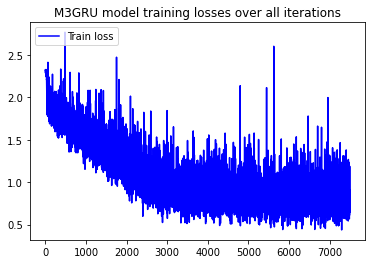

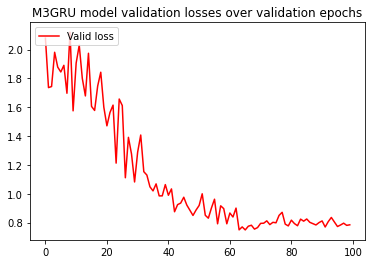

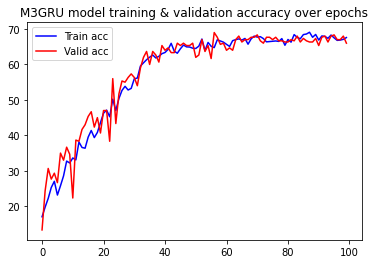

In [46]:
# Plot training loss
plt.plot(losses_train, 'b', label='Train loss')
plt.legend(loc="upper left")
plt.title("M3GRU model training losses over all iterations")
plt.show()

# Plot validation loss
plt.plot(losses_validation, 'r', label='Valid loss')
plt.legend(loc="upper left")
plt.title("M3GRU model validation losses over validation epochs")
plt.show()

# Plot accuracy
plt.plot(accuracy_train, 'b', label='Train acc')
plt.plot(accuracy_validation,'r', label ='Valid acc')
plt.legend(loc="upper left")
plt.title("M3GRU model training & validation accuracy over epochs")
plt.show()

In [47]:
M3GRU_test_acc_result, y_pred, y_true = test(model_M3GRU, n_layers=3)
print(M3GRU_test_acc_result)


Test set accuracy: 160/300 (53%)

53.333333333333336


Normalized confusion matrix


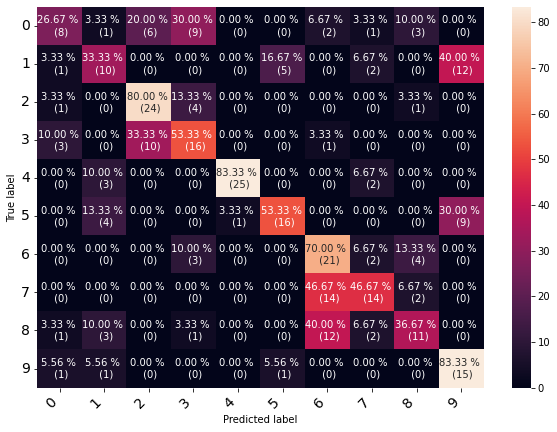

In [48]:
cf_matrix = confusion_matrix(y_true, y_pred)
print_confusion_matrix(cf_matrix, class_names = numclasses)

## M5GRU Train

In [49]:
#M5GRU train & validate
log_interval = 20


pbar_update = 1 / (len(train_loader) + len(test_loader))
losses_train = []
losses_validation = []
accuracy_train = []
accuracy_validation = []

optimiser = optim.Adam(model_M5GRU.parameters(), lr=0.01, weight_decay=0.00003)
scheduler = optim.lr_scheduler.StepLR(optimiser, step_size=32, gamma=0.1)

transform = transform.to(device)
with tqdm(total=epoch_count) as pbar:
    for epoch in range(1, epoch_count + 1):
        train(model_M5GRU, epoch, log_interval, n_layers=5)
        validate(model_M5GRU, epoch, n_layers=5)
        scheduler.step()

  0%|          | 0/100 [00:00<?, ?it/s]

Train Epoch: 1 [0/2400 (0%)]	Loss: 2.304758	Accuracy: 2/2400 (0%)
Train Epoch: 1 [640/2400 (27%)]	Loss: 2.260851	Accuracy: 78/2400 (3%)
Train Epoch: 1 [1280/2400 (53%)]	Loss: 1.996977	Accuracy: 184/2400 (8%)
Train Epoch: 1 [1920/2400 (80%)]	Loss: 1.756360	Accuracy: 314/2400 (13%)

Validation Epoch: 1 	Loss: 1.754106	Accuracy: 71/300 (24%)

Train Epoch: 2 [0/2400 (0%)]	Loss: 1.914684	Accuracy: 7/2400 (0%)
Train Epoch: 2 [640/2400 (27%)]	Loss: 1.718918	Accuracy: 162/2400 (7%)
Train Epoch: 2 [1280/2400 (53%)]	Loss: 1.791877	Accuracy: 348/2400 (14%)
Train Epoch: 2 [1920/2400 (80%)]	Loss: 1.750010	Accuracy: 498/2400 (21%)

Validation Epoch: 2 	Loss: 1.606316	Accuracy: 86/300 (29%)

Train Epoch: 3 [0/2400 (0%)]	Loss: 1.840857	Accuracy: 7/2400 (0%)
Train Epoch: 3 [640/2400 (27%)]	Loss: 1.686208	Accuracy: 193/2400 (8%)
Train Epoch: 3 [1280/2400 (53%)]	Loss: 1.914481	Accuracy: 381/2400 (16%)
Train Epoch: 3 [1920/2400 (80%)]	Loss: 1.692813	Accuracy: 565/2400 (24%)

Validation Epoch: 3 	Loss: 1.7

Train Epoch: 24 [1920/2400 (80%)]	Loss: 1.346547	Accuracy: 927/2400 (39%)

Validation Epoch: 24 	Loss: 1.167390	Accuracy: 117/300 (39%)

Train Epoch: 25 [0/2400 (0%)]	Loss: 0.866063	Accuracy: 20/2400 (1%)
Train Epoch: 25 [640/2400 (27%)]	Loss: 1.424833	Accuracy: 326/2400 (14%)
Train Epoch: 25 [1280/2400 (53%)]	Loss: 1.198761	Accuracy: 668/2400 (28%)
Train Epoch: 25 [1920/2400 (80%)]	Loss: 1.457775	Accuracy: 992/2400 (41%)

Validation Epoch: 25 	Loss: 1.650009	Accuracy: 146/300 (49%)

Train Epoch: 26 [0/2400 (0%)]	Loss: 1.169603	Accuracy: 13/2400 (1%)
Train Epoch: 26 [640/2400 (27%)]	Loss: 1.134492	Accuracy: 354/2400 (15%)
Train Epoch: 26 [1280/2400 (53%)]	Loss: 1.284680	Accuracy: 685/2400 (29%)
Train Epoch: 26 [1920/2400 (80%)]	Loss: 1.750837	Accuracy: 1010/2400 (42%)

Validation Epoch: 26 	Loss: 1.114235	Accuracy: 158/300 (53%)

Train Epoch: 27 [0/2400 (0%)]	Loss: 1.654107	Accuracy: 13/2400 (1%)
Train Epoch: 27 [640/2400 (27%)]	Loss: 1.430883	Accuracy: 334/2400 (14%)
Train Epoch: 27 [

Train Epoch: 48 [1280/2400 (53%)]	Loss: 0.612734	Accuracy: 903/2400 (38%)
Train Epoch: 48 [1920/2400 (80%)]	Loss: 0.748970	Accuracy: 1337/2400 (56%)

Validation Epoch: 48 	Loss: 1.092731	Accuracy: 180/300 (60%)

Train Epoch: 49 [0/2400 (0%)]	Loss: 0.729294	Accuracy: 23/2400 (1%)
Train Epoch: 49 [640/2400 (27%)]	Loss: 0.627108	Accuracy: 482/2400 (20%)
Train Epoch: 49 [1280/2400 (53%)]	Loss: 0.685159	Accuracy: 908/2400 (38%)
Train Epoch: 49 [1920/2400 (80%)]	Loss: 0.827089	Accuracy: 1347/2400 (56%)

Validation Epoch: 49 	Loss: 1.064885	Accuracy: 180/300 (60%)

Train Epoch: 50 [0/2400 (0%)]	Loss: 0.679048	Accuracy: 23/2400 (1%)
Train Epoch: 50 [640/2400 (27%)]	Loss: 0.791090	Accuracy: 470/2400 (20%)
Train Epoch: 50 [1280/2400 (53%)]	Loss: 0.758139	Accuracy: 918/2400 (38%)
Train Epoch: 50 [1920/2400 (80%)]	Loss: 0.513070	Accuracy: 1355/2400 (56%)

Validation Epoch: 50 	Loss: 0.960284	Accuracy: 181/300 (60%)

Train Epoch: 51 [0/2400 (0%)]	Loss: 1.142173	Accuracy: 17/2400 (1%)
Train Epoch: 5


Validation Epoch: 71 	Loss: 1.092770	Accuracy: 202/300 (67%)

Train Epoch: 72 [0/2400 (0%)]	Loss: 0.701358	Accuracy: 23/2400 (1%)
Train Epoch: 72 [640/2400 (27%)]	Loss: 0.674851	Accuracy: 490/2400 (20%)
Train Epoch: 72 [1280/2400 (53%)]	Loss: 0.797359	Accuracy: 933/2400 (39%)
Train Epoch: 72 [1920/2400 (80%)]	Loss: 0.498181	Accuracy: 1407/2400 (59%)

Validation Epoch: 72 	Loss: 0.989570	Accuracy: 202/300 (67%)

Train Epoch: 73 [0/2400 (0%)]	Loss: 0.501680	Accuracy: 27/2400 (1%)
Train Epoch: 73 [640/2400 (27%)]	Loss: 0.614515	Accuracy: 486/2400 (20%)
Train Epoch: 73 [1280/2400 (53%)]	Loss: 0.574353	Accuracy: 943/2400 (39%)
Train Epoch: 73 [1920/2400 (80%)]	Loss: 0.549867	Accuracy: 1398/2400 (58%)

Validation Epoch: 73 	Loss: 1.038062	Accuracy: 199/300 (66%)

Train Epoch: 74 [0/2400 (0%)]	Loss: 0.631259	Accuracy: 24/2400 (1%)
Train Epoch: 74 [640/2400 (27%)]	Loss: 0.541110	Accuracy: 488/2400 (20%)
Train Epoch: 74 [1280/2400 (53%)]	Loss: 0.803195	Accuracy: 962/2400 (40%)
Train Epoch: 74 

Train Epoch: 95 [1280/2400 (53%)]	Loss: 0.974063	Accuracy: 954/2400 (40%)
Train Epoch: 95 [1920/2400 (80%)]	Loss: 0.473690	Accuracy: 1416/2400 (59%)

Validation Epoch: 95 	Loss: 1.027413	Accuracy: 200/300 (67%)

Train Epoch: 96 [0/2400 (0%)]	Loss: 0.702896	Accuracy: 20/2400 (1%)
Train Epoch: 96 [640/2400 (27%)]	Loss: 0.544395	Accuracy: 490/2400 (20%)
Train Epoch: 96 [1280/2400 (53%)]	Loss: 0.756054	Accuracy: 950/2400 (40%)
Train Epoch: 96 [1920/2400 (80%)]	Loss: 0.625582	Accuracy: 1421/2400 (59%)

Validation Epoch: 96 	Loss: 0.940834	Accuracy: 201/300 (67%)

Train Epoch: 97 [0/2400 (0%)]	Loss: 0.669620	Accuracy: 26/2400 (1%)
Train Epoch: 97 [640/2400 (27%)]	Loss: 0.691345	Accuracy: 478/2400 (20%)
Train Epoch: 97 [1280/2400 (53%)]	Loss: 0.748405	Accuracy: 957/2400 (40%)
Train Epoch: 97 [1920/2400 (80%)]	Loss: 0.639475	Accuracy: 1424/2400 (59%)

Validation Epoch: 97 	Loss: 1.006521	Accuracy: 205/300 (68%)

Train Epoch: 98 [0/2400 (0%)]	Loss: 0.610589	Accuracy: 28/2400 (1%)
Train Epoch: 9

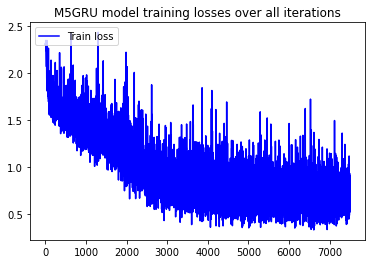

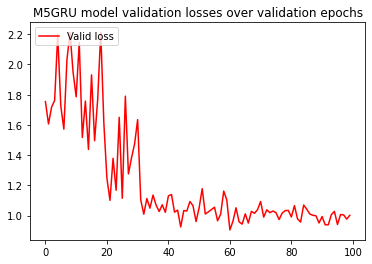

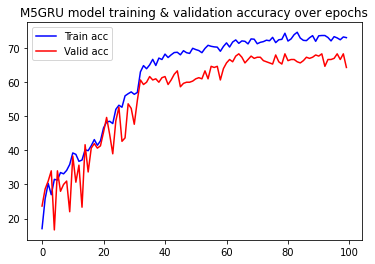

In [50]:
# Plot training loss
plt.plot(losses_train, 'b', label='Train loss')
plt.legend(loc="upper left")
plt.title("M5GRU model training losses over all iterations")
plt.show()

# Plot validation loss
plt.plot(losses_validation, 'r', label='Valid loss')
plt.legend(loc="upper left")
plt.title("M5GRU model validation losses over validation epochs")
plt.show()

# Plot accuracy
plt.plot(accuracy_train, 'b', label='Train acc')
plt.plot(accuracy_validation,'r', label ='Valid acc')
plt.legend(loc="upper left")
plt.title("M5GRU model training & validation accuracy over epochs")
plt.show()

In [51]:
M5GRU_test_acc_result, y_pred, y_true = test(model_M5GRU, n_layers=5)
print(M5GRU_test_acc_result)


Test set accuracy: 188/300 (63%)

62.666666666666664


Normalized confusion matrix


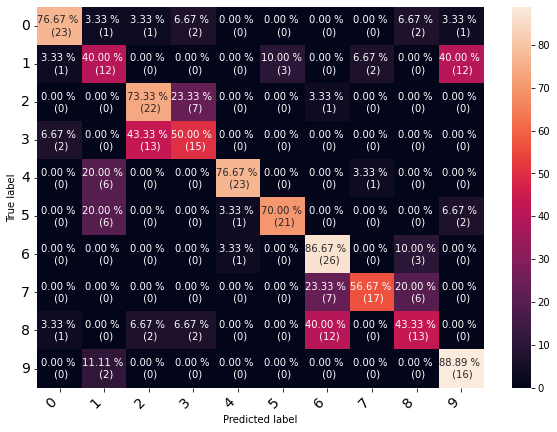

In [52]:
cf_matrix = confusion_matrix(y_true, y_pred)
print_confusion_matrix(cf_matrix, class_names = numclasses)

## M11GRU Train

In [53]:
#M11GRU train & validate
log_interval = 20

pbar_update = 1 / (len(train_loader) + len(test_loader))
losses_train = []
losses_validation = []
accuracy_train = []
accuracy_validation = []

optimiser = optim.Adam(model_M11GRU.parameters(), lr=0.0002, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimiser, step_size=32, gamma=0.1)

transform = transform.to(device)
with tqdm(total=epoch_count) as pbar:
    for epoch in range(1, epoch_count + 1):
        train(model_M11GRU, epoch, log_interval, n_layers=11)
        validate(model_M11GRU, epoch, n_layers=11)
        scheduler.step()

  0%|          | 0/100 [00:00<?, ?it/s]

Train Epoch: 1 [0/2400 (0%)]	Loss: 2.311013	Accuracy: 6/2400 (0%)
Train Epoch: 1 [640/2400 (27%)]	Loss: 2.279670	Accuracy: 62/2400 (3%)
Train Epoch: 1 [1280/2400 (53%)]	Loss: 2.330555	Accuracy: 130/2400 (5%)
Train Epoch: 1 [1920/2400 (80%)]	Loss: 2.295414	Accuracy: 193/2400 (8%)

Validation Epoch: 1 	Loss: 2.357018	Accuracy: 30/300 (10%)

Train Epoch: 2 [0/2400 (0%)]	Loss: 2.263969	Accuracy: 5/2400 (0%)
Train Epoch: 2 [640/2400 (27%)]	Loss: 2.304183	Accuracy: 94/2400 (4%)
Train Epoch: 2 [1280/2400 (53%)]	Loss: 2.268077	Accuracy: 183/2400 (8%)
Train Epoch: 2 [1920/2400 (80%)]	Loss: 2.220760	Accuracy: 296/2400 (12%)

Validation Epoch: 2 	Loss: 2.458159	Accuracy: 45/300 (15%)

Train Epoch: 3 [0/2400 (0%)]	Loss: 2.206782	Accuracy: 11/2400 (0%)
Train Epoch: 3 [640/2400 (27%)]	Loss: 2.105664	Accuracy: 146/2400 (6%)
Train Epoch: 3 [1280/2400 (53%)]	Loss: 2.030141	Accuracy: 314/2400 (13%)
Train Epoch: 3 [1920/2400 (80%)]	Loss: 2.022032	Accuracy: 482/2400 (20%)

Validation Epoch: 3 	Loss: 2.394

Train Epoch: 24 [1920/2400 (80%)]	Loss: 0.829770	Accuracy: 1467/2400 (61%)

Validation Epoch: 24 	Loss: 3.433129	Accuracy: 40/300 (13%)

Train Epoch: 25 [0/2400 (0%)]	Loss: 1.046478	Accuracy: 20/2400 (1%)
Train Epoch: 25 [640/2400 (27%)]	Loss: 0.835183	Accuracy: 489/2400 (20%)
Train Epoch: 25 [1280/2400 (53%)]	Loss: 0.745929	Accuracy: 986/2400 (41%)
Train Epoch: 25 [1920/2400 (80%)]	Loss: 0.661875	Accuracy: 1481/2400 (62%)

Validation Epoch: 25 	Loss: 3.346013	Accuracy: 52/300 (17%)

Train Epoch: 26 [0/2400 (0%)]	Loss: 0.733492	Accuracy: 24/2400 (1%)
Train Epoch: 26 [640/2400 (27%)]	Loss: 0.684670	Accuracy: 501/2400 (21%)
Train Epoch: 26 [1280/2400 (53%)]	Loss: 0.754237	Accuracy: 987/2400 (41%)
Train Epoch: 26 [1920/2400 (80%)]	Loss: 0.702723	Accuracy: 1474/2400 (61%)

Validation Epoch: 26 	Loss: 3.242039	Accuracy: 45/300 (15%)

Train Epoch: 27 [0/2400 (0%)]	Loss: 0.631576	Accuracy: 28/2400 (1%)
Train Epoch: 27 [640/2400 (27%)]	Loss: 0.673493	Accuracy: 507/2400 (21%)
Train Epoch: 27 [1

Train Epoch: 48 [640/2400 (27%)]	Loss: 0.561431	Accuracy: 537/2400 (22%)
Train Epoch: 48 [1280/2400 (53%)]	Loss: 0.584143	Accuracy: 1058/2400 (44%)
Train Epoch: 48 [1920/2400 (80%)]	Loss: 0.574747	Accuracy: 1581/2400 (66%)

Validation Epoch: 48 	Loss: 3.105430	Accuracy: 52/300 (17%)

Train Epoch: 49 [0/2400 (0%)]	Loss: 0.636319	Accuracy: 25/2400 (1%)
Train Epoch: 49 [640/2400 (27%)]	Loss: 0.451196	Accuracy: 557/2400 (23%)
Train Epoch: 49 [1280/2400 (53%)]	Loss: 0.622558	Accuracy: 1083/2400 (45%)
Train Epoch: 49 [1920/2400 (80%)]	Loss: 0.434248	Accuracy: 1599/2400 (67%)

Validation Epoch: 49 	Loss: 3.137751	Accuracy: 41/300 (14%)

Train Epoch: 50 [0/2400 (0%)]	Loss: 0.634160	Accuracy: 22/2400 (1%)
Train Epoch: 50 [640/2400 (27%)]	Loss: 0.446144	Accuracy: 532/2400 (22%)
Train Epoch: 50 [1280/2400 (53%)]	Loss: 0.430168	Accuracy: 1067/2400 (44%)
Train Epoch: 50 [1920/2400 (80%)]	Loss: 0.541584	Accuracy: 1581/2400 (66%)

Validation Epoch: 50 	Loss: 3.028668	Accuracy: 50/300 (17%)

Train Epo

Train Epoch: 71 [1920/2400 (80%)]	Loss: 0.490398	Accuracy: 1605/2400 (67%)

Validation Epoch: 71 	Loss: 3.084536	Accuracy: 38/300 (13%)

Train Epoch: 72 [0/2400 (0%)]	Loss: 0.611012	Accuracy: 27/2400 (1%)
Train Epoch: 72 [640/2400 (27%)]	Loss: 0.409295	Accuracy: 553/2400 (23%)
Train Epoch: 72 [1280/2400 (53%)]	Loss: 0.486735	Accuracy: 1085/2400 (45%)
Train Epoch: 72 [1920/2400 (80%)]	Loss: 0.452531	Accuracy: 1617/2400 (67%)

Validation Epoch: 72 	Loss: 3.063249	Accuracy: 49/300 (16%)

Train Epoch: 73 [0/2400 (0%)]	Loss: 0.562132	Accuracy: 29/2400 (1%)
Train Epoch: 73 [640/2400 (27%)]	Loss: 0.443199	Accuracy: 576/2400 (24%)
Train Epoch: 73 [1280/2400 (53%)]	Loss: 0.500442	Accuracy: 1084/2400 (45%)
Train Epoch: 73 [1920/2400 (80%)]	Loss: 0.364329	Accuracy: 1606/2400 (67%)

Validation Epoch: 73 	Loss: 3.145943	Accuracy: 39/300 (13%)

Train Epoch: 74 [0/2400 (0%)]	Loss: 0.544580	Accuracy: 29/2400 (1%)
Train Epoch: 74 [640/2400 (27%)]	Loss: 0.489718	Accuracy: 560/2400 (23%)
Train Epoch: 74 

Train Epoch: 95 [640/2400 (27%)]	Loss: 0.422872	Accuracy: 566/2400 (24%)
Train Epoch: 95 [1280/2400 (53%)]	Loss: 0.493456	Accuracy: 1105/2400 (46%)
Train Epoch: 95 [1920/2400 (80%)]	Loss: 0.550253	Accuracy: 1629/2400 (68%)

Validation Epoch: 95 	Loss: 3.200508	Accuracy: 36/300 (12%)

Train Epoch: 96 [0/2400 (0%)]	Loss: 0.603531	Accuracy: 25/2400 (1%)
Train Epoch: 96 [640/2400 (27%)]	Loss: 0.439657	Accuracy: 558/2400 (23%)
Train Epoch: 96 [1280/2400 (53%)]	Loss: 0.470571	Accuracy: 1094/2400 (46%)
Train Epoch: 96 [1920/2400 (80%)]	Loss: 0.483049	Accuracy: 1610/2400 (67%)

Validation Epoch: 96 	Loss: 3.323143	Accuracy: 34/300 (11%)

Train Epoch: 97 [0/2400 (0%)]	Loss: 0.570114	Accuracy: 25/2400 (1%)
Train Epoch: 97 [640/2400 (27%)]	Loss: 0.503771	Accuracy: 551/2400 (23%)
Train Epoch: 97 [1280/2400 (53%)]	Loss: 0.456623	Accuracy: 1083/2400 (45%)
Train Epoch: 97 [1920/2400 (80%)]	Loss: 0.479934	Accuracy: 1611/2400 (67%)

Validation Epoch: 97 	Loss: 3.065950	Accuracy: 50/300 (17%)

Train Epo

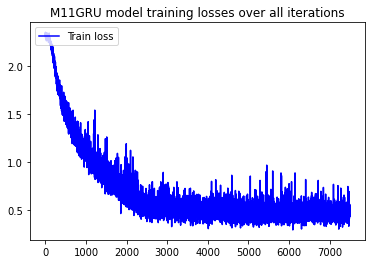

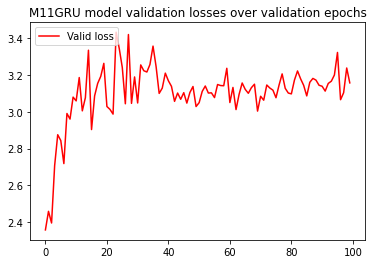

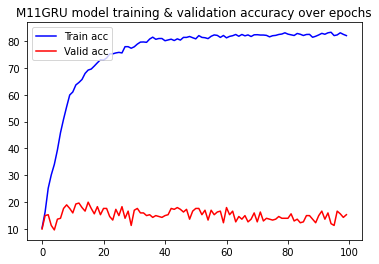

In [54]:
# Plot training loss
plt.plot(losses_train, 'b', label='Train loss')
plt.legend(loc="upper left")
plt.title("M11GRU model training losses over all iterations")
plt.show()

# Plot validation loss
plt.plot(losses_validation, 'r', label='Valid loss')
plt.legend(loc="upper left")
plt.title("M11GRU model validation losses over validation epochs")
plt.show()

# Plot accuracy
plt.plot(accuracy_train, 'b', label='Train acc')
plt.plot(accuracy_validation,'r', label ='Valid acc')
plt.legend(loc="upper left")
plt.title("M11GRU model training & validation accuracy over epochs")
plt.show()

In [55]:
M11GRU_test_acc_result, y_pred, y_true = test(model_M11GRU, n_layers=11)
print(M11GRU_test_acc_result)


Test set accuracy: 36/300 (12%)

12.0


Normalized confusion matrix


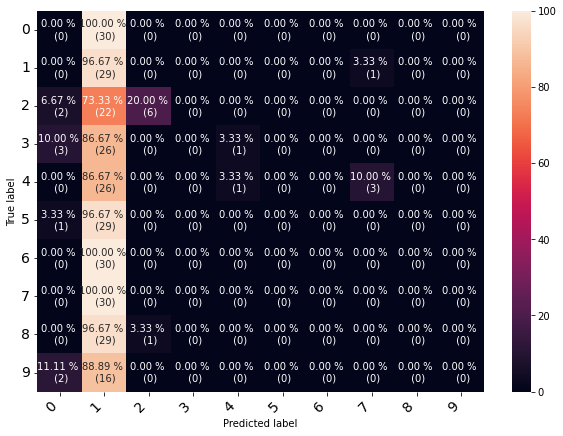

In [56]:
cf_matrix = confusion_matrix(y_true, y_pred)
print_confusion_matrix(cf_matrix, class_names = numclasses)

## M18GRU Train

In [57]:
#M18GRU train & validate
log_interval = 20

pbar_update = 1 / (len(train_loader) + len(test_loader))
losses_train = []
losses_validation = []
accuracy_train = []
accuracy_validation = []

optimiser = optim.Adam(model_M18GRU.parameters(), lr=0.001, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimiser, step_size=32, gamma=0.1)

transform = transform.to(device)
with tqdm(total=epoch_count) as pbar:
    for epoch in range(1, epoch_count + 1):
        train(model_M18GRU, epoch, log_interval, n_layers=18)
        validate(model_M18GRU, epoch, n_layers=18)
        scheduler.step()

  0%|          | 0/100 [00:00<?, ?it/s]

Train Epoch: 1 [0/2400 (0%)]	Loss: 2.307777	Accuracy: 4/2400 (0%)
Train Epoch: 1 [640/2400 (27%)]	Loss: 2.288122	Accuracy: 72/2400 (3%)
Train Epoch: 1 [1280/2400 (53%)]	Loss: 2.258254	Accuracy: 170/2400 (7%)
Train Epoch: 1 [1920/2400 (80%)]	Loss: 2.185275	Accuracy: 281/2400 (12%)

Validation Epoch: 1 	Loss: 2.398659	Accuracy: 42/300 (14%)

Train Epoch: 2 [0/2400 (0%)]	Loss: 2.102913	Accuracy: 6/2400 (0%)
Train Epoch: 2 [640/2400 (27%)]	Loss: 2.042636	Accuracy: 154/2400 (6%)
Train Epoch: 2 [1280/2400 (53%)]	Loss: 1.968907	Accuracy: 318/2400 (13%)
Train Epoch: 2 [1920/2400 (80%)]	Loss: 1.916530	Accuracy: 519/2400 (22%)

Validation Epoch: 2 	Loss: 1.990792	Accuracy: 76/300 (25%)

Train Epoch: 3 [0/2400 (0%)]	Loss: 1.811291	Accuracy: 14/2400 (1%)
Train Epoch: 3 [640/2400 (27%)]	Loss: 1.804844	Accuracy: 212/2400 (9%)
Train Epoch: 3 [1280/2400 (53%)]	Loss: 1.843790	Accuracy: 408/2400 (17%)
Train Epoch: 3 [1920/2400 (80%)]	Loss: 1.812120	Accuracy: 615/2400 (26%)

Validation Epoch: 3 	Loss: 1.

Train Epoch: 24 [1280/2400 (53%)]	Loss: 0.367999	Accuracy: 1160/2400 (48%)
Train Epoch: 24 [1920/2400 (80%)]	Loss: 0.546733	Accuracy: 1732/2400 (72%)

Validation Epoch: 24 	Loss: 0.294620	Accuracy: 258/300 (86%)

Train Epoch: 25 [0/2400 (0%)]	Loss: 0.350085	Accuracy: 27/2400 (1%)
Train Epoch: 25 [640/2400 (27%)]	Loss: 0.393119	Accuracy: 614/2400 (26%)
Train Epoch: 25 [1280/2400 (53%)]	Loss: 0.154930	Accuracy: 1197/2400 (50%)
Train Epoch: 25 [1920/2400 (80%)]	Loss: 0.342434	Accuracy: 1763/2400 (73%)

Validation Epoch: 25 	Loss: 0.648643	Accuracy: 256/300 (85%)

Train Epoch: 26 [0/2400 (0%)]	Loss: 0.269932	Accuracy: 31/2400 (1%)
Train Epoch: 26 [640/2400 (27%)]	Loss: 0.127142	Accuracy: 612/2400 (26%)
Train Epoch: 26 [1280/2400 (53%)]	Loss: 0.361260	Accuracy: 1188/2400 (50%)
Train Epoch: 26 [1920/2400 (80%)]	Loss: 0.614137	Accuracy: 1756/2400 (73%)

Validation Epoch: 26 	Loss: 0.494447	Accuracy: 246/300 (82%)

Train Epoch: 27 [0/2400 (0%)]	Loss: 0.288718	Accuracy: 29/2400 (1%)
Train Epoch

Train Epoch: 47 [1920/2400 (80%)]	Loss: 0.041136	Accuracy: 1919/2400 (80%)

Validation Epoch: 47 	Loss: 0.106645	Accuracy: 281/300 (94%)

Train Epoch: 48 [0/2400 (0%)]	Loss: 0.068788	Accuracy: 32/2400 (1%)
Train Epoch: 48 [640/2400 (27%)]	Loss: 0.074388	Accuracy: 657/2400 (27%)
Train Epoch: 48 [1280/2400 (53%)]	Loss: 0.083520	Accuracy: 1291/2400 (54%)
Train Epoch: 48 [1920/2400 (80%)]	Loss: 0.038656	Accuracy: 1916/2400 (80%)

Validation Epoch: 48 	Loss: 0.112203	Accuracy: 280/300 (93%)

Train Epoch: 49 [0/2400 (0%)]	Loss: 0.077458	Accuracy: 31/2400 (1%)
Train Epoch: 49 [640/2400 (27%)]	Loss: 0.135586	Accuracy: 659/2400 (27%)
Train Epoch: 49 [1280/2400 (53%)]	Loss: 0.100350	Accuracy: 1289/2400 (54%)
Train Epoch: 49 [1920/2400 (80%)]	Loss: 0.080208	Accuracy: 1919/2400 (80%)

Validation Epoch: 49 	Loss: 0.081843	Accuracy: 282/300 (94%)

Train Epoch: 50 [0/2400 (0%)]	Loss: 0.053830	Accuracy: 32/2400 (1%)
Train Epoch: 50 [640/2400 (27%)]	Loss: 0.044375	Accuracy: 661/2400 (28%)
Train Epoch: 


Validation Epoch: 70 	Loss: 0.134828	Accuracy: 279/300 (93%)

Train Epoch: 71 [0/2400 (0%)]	Loss: 0.078433	Accuracy: 32/2400 (1%)
Train Epoch: 71 [640/2400 (27%)]	Loss: 0.034387	Accuracy: 671/2400 (28%)
Train Epoch: 71 [1280/2400 (53%)]	Loss: 0.074546	Accuracy: 1303/2400 (54%)
Train Epoch: 71 [1920/2400 (80%)]	Loss: 0.034938	Accuracy: 1939/2400 (81%)

Validation Epoch: 71 	Loss: 0.156279	Accuracy: 279/300 (93%)

Train Epoch: 72 [0/2400 (0%)]	Loss: 0.047837	Accuracy: 32/2400 (1%)
Train Epoch: 72 [640/2400 (27%)]	Loss: 0.027558	Accuracy: 667/2400 (28%)
Train Epoch: 72 [1280/2400 (53%)]	Loss: 0.029901	Accuracy: 1306/2400 (54%)
Train Epoch: 72 [1920/2400 (80%)]	Loss: 0.029039	Accuracy: 1936/2400 (81%)

Validation Epoch: 72 	Loss: 0.055983	Accuracy: 281/300 (94%)

Train Epoch: 73 [0/2400 (0%)]	Loss: 0.136044	Accuracy: 31/2400 (1%)
Train Epoch: 73 [640/2400 (27%)]	Loss: 0.098050	Accuracy: 668/2400 (28%)
Train Epoch: 73 [1280/2400 (53%)]	Loss: 0.028326	Accuracy: 1301/2400 (54%)
Train Epoch: 

Train Epoch: 94 [640/2400 (27%)]	Loss: 0.028564	Accuracy: 662/2400 (28%)
Train Epoch: 94 [1280/2400 (53%)]	Loss: 0.030146	Accuracy: 1299/2400 (54%)
Train Epoch: 94 [1920/2400 (80%)]	Loss: 0.033547	Accuracy: 1935/2400 (81%)

Validation Epoch: 94 	Loss: 0.044789	Accuracy: 282/300 (94%)

Train Epoch: 95 [0/2400 (0%)]	Loss: 0.043282	Accuracy: 32/2400 (1%)
Train Epoch: 95 [640/2400 (27%)]	Loss: 0.034425	Accuracy: 671/2400 (28%)
Train Epoch: 95 [1280/2400 (53%)]	Loss: 0.062429	Accuracy: 1308/2400 (54%)
Train Epoch: 95 [1920/2400 (80%)]	Loss: 0.042672	Accuracy: 1945/2400 (81%)

Validation Epoch: 95 	Loss: 0.145041	Accuracy: 281/300 (94%)

Train Epoch: 96 [0/2400 (0%)]	Loss: 0.048655	Accuracy: 32/2400 (1%)
Train Epoch: 96 [640/2400 (27%)]	Loss: 0.029033	Accuracy: 666/2400 (28%)
Train Epoch: 96 [1280/2400 (53%)]	Loss: 0.062145	Accuracy: 1300/2400 (54%)
Train Epoch: 96 [1920/2400 (80%)]	Loss: 0.025996	Accuracy: 1936/2400 (81%)

Validation Epoch: 96 	Loss: 0.094572	Accuracy: 282/300 (94%)

Train 

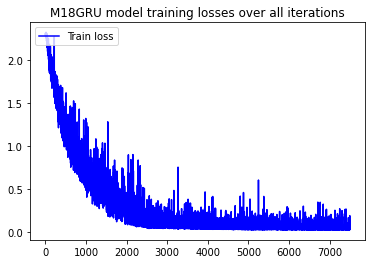

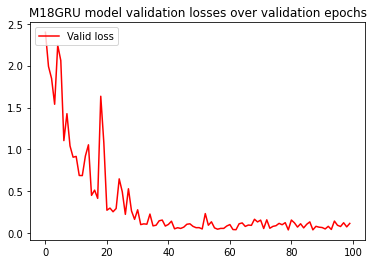

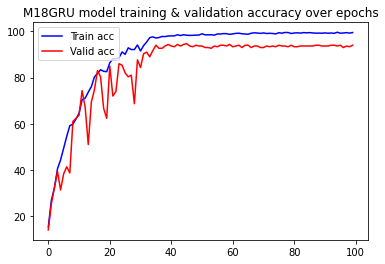

In [58]:
# Plot training loss
plt.plot(losses_train, 'b', label='Train loss')
plt.legend(loc="upper left")
plt.title("M18GRU model training losses over all iterations")
plt.show()

# Plot validation loss
plt.plot(losses_validation, 'r', label='Valid loss')
plt.legend(loc="upper left")
plt.title("M18GRU model validation losses over validation epochs")
plt.show()

# Plot accuracy
plt.plot(accuracy_train, 'b', label='Train acc')
plt.plot(accuracy_validation,'r', label ='Valid acc')
plt.legend(loc="upper left")
plt.title("M18GRU model training & validation accuracy over epochs")
plt.show()

In [59]:
M18GRU_test_acc_result, y_pred, y_true = test(model_M18GRU, n_layers=18)
print(M18GRU_test_acc_result)


Test set accuracy: 279/300 (93%)

93.0


Normalized confusion matrix


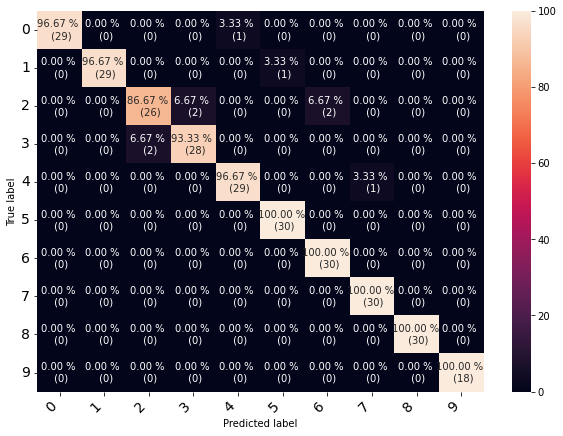

In [60]:
cf_matrix = confusion_matrix(y_true, y_pred)
print_confusion_matrix(cf_matrix, class_names = numclasses)

In [61]:
print('Number of epochs:', epoch_count)
print(f"\nM3GRU model accuracy: {(M3GRU_test_acc_result):.0f}%")
print(f"M5GRU model accuracy: {(M5GRU_test_acc_result):.0f}%")
print(f"M11GRU model accuracy: {(M11GRU_test_acc_result):.0f}%")
print(f"M18GRU model accuracy: {(M18GRU_test_acc_result):.0f}%")

Number of epochs: 100

M3GRU model accuracy: 53%
M5GRU model accuracy: 63%
M11GRU model accuracy: 12%
M18GRU model accuracy: 93%
